In [1]:
# importa as bibliotecas que serão utilizadas.
import pandas as pd
import numpy as np
import json

In [2]:
path_main = '/home/jovyan/work/lucas/lucas-egc/estudo_caso'

##### Padronizando nomes dos órgaos da administração direta

In [3]:
# padroniza os nomes dos órgãos da administração direta 
# conforme dicionário json criado com as informações do
# notebook padronizacao_nomes_orgaos.ipynb

def ajustar_nome_orgao(valor: str) -> str:
    path_json = path_main +'/padronizacao_orgaos.json'
    with open(path_json, "r", encoding="utf-8") as f:
        orgaos_padronizados = json.load(f)

    for para, de in orgaos_padronizados.items():
        if valor in de:
            return para
            
    return valor
    

#### IACM

In [4]:
# carrega para o estudo de caso as informações do iacm
# armazenadas no arquivo csv gerado no notebook
# apendice_A-cumprimento_metas.ipynb
path_iacm = path_main + '/iacm_orgaos_anos_media.csv'
df_iacm = pd.read_csv(path_iacm)
df_iacm['ORGAO'] = df_iacm['ORGAO'].apply(ajustar_nome_orgao)
#df_iacm = df_iacm.set_index('ORGAO')
df_iacm.head()

,ORGAO,2021,2022,2023,2024,MEDIA
0,Secretaria Municipal de Mobilidade e Trânsito,100.0,50.60,77.73,39.67,67.0000
1,Secretaria Municipal de Inovação e Tecnologia,100.0,23.46,61.04,91.71,69.0525
2,Secretaria Municipal de Infraestrutura Urbana ...,100.0,64.73,77.94,51.50,73.5425
3,Secretaria Municipal de Cultura,100.0,66.67,60.00,72.58,74.8125
4,Secretaria Municipal de Segurança Urbana,0.0,100.00,100.00,100.00,75.0000


#### Rotatividade

In [18]:
# carrega para o estudo de caso as informações da rotatividade armazenadas 
# no arquivo csv gerado no notebook apendice_B-rotatividade.ipynb
path_rotatividade_pmsp = path_main + '/taxa_rotatividade_pmsp_anual.csv'
df_rotatividade_pmsp = pd.read_csv(path_rotatividade_pmsp)


In [19]:
# carrega para o estudo de caso as informações da rotatividade armazenadas 
# no arquivo csv gerado no notebook apendice_B-rotatividade.ipynb
path_rotatividade = path_main + '/taxa_rotatividade_secret_subpref_anual.csv'
df_rotatividade = pd.read_csv(path_rotatividade)
df_rotatividade['ORGAO'] = df_rotatividade['SECRET_SUBPREF'].apply(ajustar_nome_orgao)
df_rotatividade = df_rotatividade[['ORGAO','ANO','TAXA_ROTATIVIDADE','TAXA_ROTATIVIDADE_COMISSAO']].merge(df_rotatividade_pmsp, on='ANO', how='inner', suffixes=('_ORGAO','_PMSP'))


#### Efetivos em comissão

In [20]:
# carrega para o estudo de caso as informações da rotatividade armazenadas 
# no arquivo csv gerado no notebook apendice_B-rotatividade.ipynb
path_efetivos_comissao = path_main + '/percentual_efetivos_media_anual.csv'
df_efetivos_comissao = pd.read_csv(path_efetivos_comissao)
df_efetivos_comissao['ORGAO'] = df_efetivos_comissao['SECRET_SUBPREF'].apply(ajustar_nome_orgao)
df_efetivos_comissao = df_efetivos_comissao[['ORGAO','ANO','CDA_AGREGADOS','PERCENTUAL_EFETIVOS','PERCENTUAL_LEGAL']]


## Correlações

In [21]:
# Supondo que df seja o seu DataFrame
df_somente_iacm = df_iacm.drop(columns=["MEDIA"])  # remove a coluna MEDIA

# faz a transformação
df_iacm_long = df_somente_iacm.melt(
    id_vars=["ORGAO"],          # mantém essa coluna fixa
    value_vars=["2021", "2022", "2023", "2024"],  # colunas que serão "derretidas"
    var_name="ANO",             # nome da nova coluna que terá os anos
    value_name="IACM"           # nome da coluna com os valores
)
df_iacm_long['ANO'] = df_iacm_long['ANO'].astype(int)

##### IACM x Rotatividade

In [22]:
# Copia as informações da rotatividade para outra tabela
df_rotatividade_long = df_rotatividade.copy()

In [23]:
# Junta as informações do IACM dos órgãos, ano a ano, com as taxas de rotatividade
df_iam_rotatividade = df_iacm_long.merge(df_rotatividade_long, on=['ORGAO','ANO'], how='inner')

In [24]:
# Remove as colunas ORGAO e ANO e as linhas que não possuem o IACM definido
df_iam_rotatividade = df_iam_rotatividade[['IACM','TAXA_ROTATIVIDADE_ORGAO', 'TAXA_ROTATIVIDADE_COMISSAO_ORGAO']]
df_iam_rotatividade = df_iam_rotatividade.dropna(subset='IACM')

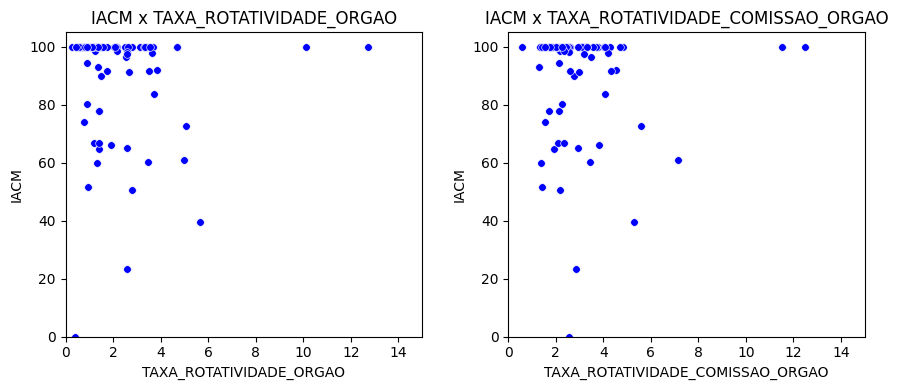

In [25]:
# Exibi os gráficos com os valores do IACM e as taxas de rotatividade 
# (TAXA_ROTATIVIDADE_ORGAO e TAXA_ROTATIVIDADE_COMISSAO_ORGAO)
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
ax = axes[0]
sns.scatterplot(data=df_iam_rotatividade[['IACM','TAXA_ROTATIVIDADE_ORGAO']], x='TAXA_ROTATIVIDADE_ORGAO', y='IACM', ax=ax, s=30, color='blue')
ax.set_xlim(0, 15)
ax.set_ylim(0, 105)
ax.set_title(f'IACM x TAXA_ROTATIVIDADE_ORGAO')

ax = axes[1]
sns.scatterplot(data=df_iam_rotatividade[['IACM','TAXA_ROTATIVIDADE_COMISSAO_ORGAO']], x='TAXA_ROTATIVIDADE_COMISSAO_ORGAO', y='IACM', ax=ax, s=30, color='blue')
ax.set_xlim(0, 15)
ax.set_ylim(0, 105)
ax.set_title(f'IACM x TAXA_ROTATIVIDADE_COMISSAO_ORGAO')

plt.tight_layout()
plt.savefig("figura_C1.png")
plt.show()

In [26]:
# Cria a tabela com o cálculo da correlação estatística entre as variáveis
pearson = df_iam_rotatividade.corr(numeric_only=True, method="pearson")['IACM']
spearman = df_iam_rotatividade.corr(numeric_only=True, method="spearman")['IACM']
kendall = df_iam_rotatividade.corr(numeric_only=True, method="kendall")['IACM']
df_iam_rotatividade_corr = pd.DataFrame(pearson).rename(columns={'IACM':'Pearson'})
df_iam_rotatividade_corr = pd.concat([df_iam_rotatividade_corr, pd.DataFrame(spearman).rename(columns={'IACM':'Spearman'})], axis=1)
df_iam_rotatividade_corr = pd.concat([df_iam_rotatividade_corr, pd.DataFrame(kendall).rename(columns={'IACM':'Kendall'})], axis=1)
df_iam_rotatividade_corr.to_html('tabela_C1.html')
df_iam_rotatividade_corr

,Pearson,Spearman,Kendall
IACM,1.000000,1.000000,1.000000
TAXA_ROTATIVIDADE_ORGAO,0.043721,-0.191446,-0.142323
TAXA_ROTATIVIDADE_COMISSAO_ORGAO,0.043124,-0.046121,-0.031875


📌 **1) IACM vs TAXA_ROTATIVIDADE_ORGAO**

**✔ Pearson: 0.0437:**
Correlação positiva muito fraca. Praticamente nula. Não há relação linear significativa entre IACM e a rotatividade geral do órgão

**✔ Spearman: –0.1914:**
Correlação negativa fraca. Isso indica que, ao comparar apenas a ordem das observações, existe uma tendência fraca de que órgãos com maior rotatividade tendem a ter IACM um pouco menor — mas a relação é muito fraca.

**✔ Kendall: –0.1423:**
Confirma a leitura do Spearman. Há tendência fraca e negativa, mas não é forte o suficiente para indicar uma relação monotônica consistente.

🎯 **Conclusão desse par:**

✔ Não há correlação estatisticamente significativa.
✔ Pode haver uma leve tendência inversa, mas muito fraca.
✔ Nada que indique que o IACM varia em função clara da rotatividade geral.

📌 **2) IACM vs TAXA_ROTATIVIDADE_COMISSAO_ORGAO**

**✔ Pearson: 0.0431:**
Correlação positiva muito fraca. Irrelevante do ponto de vista estatístico

**✔ Spearman: –0.0461:**
Correlação negativa quase nula. Indica que a ordenação dos valores não segue padrão de aumento/diminuição entre as variáveis

**✔ Kendall: –0.0318:**
Confirma o Spearman: correlação praticamente inexistente

🎯 **Conclusão desse par:**

✔ Não há relação linear entre IACM e rotatividade de comissionados
✔ Também não há relação monotônica
✔ A variação no IACM não se explica pela rotatividade de comissionados


##### IACM x Efetivos em comissão

In [27]:
# Estrutura a tabela com as informações dos percentuais de servidores 
# efetivos em cargos de comissão, mantendo a relação dos órgãos e separando
# os percentuais por níveis de cargos em colunas
df_efetivos_comissao_long = df_efetivos_comissao[['ORGAO','ANO','CDA_AGREGADOS','PERCENTUAL_EFETIVOS']].pivot(index=['ORGAO','ANO'], columns='CDA_AGREGADOS', values='PERCENTUAL_EFETIVOS').reset_index()

In [28]:
# Junta as informações do IACM dos órgãos, ano a ano, com os
# percentuais dos servidores efetivos em cargos de comissão
df_iam_efetivos_comissao = df_iacm_long.merge(df_efetivos_comissao_long, on=['ORGAO','ANO'], how='inner')
df_iam_efetivos_comissao = df_iam_efetivos_comissao.drop(columns=['ANO','ORGAO'])

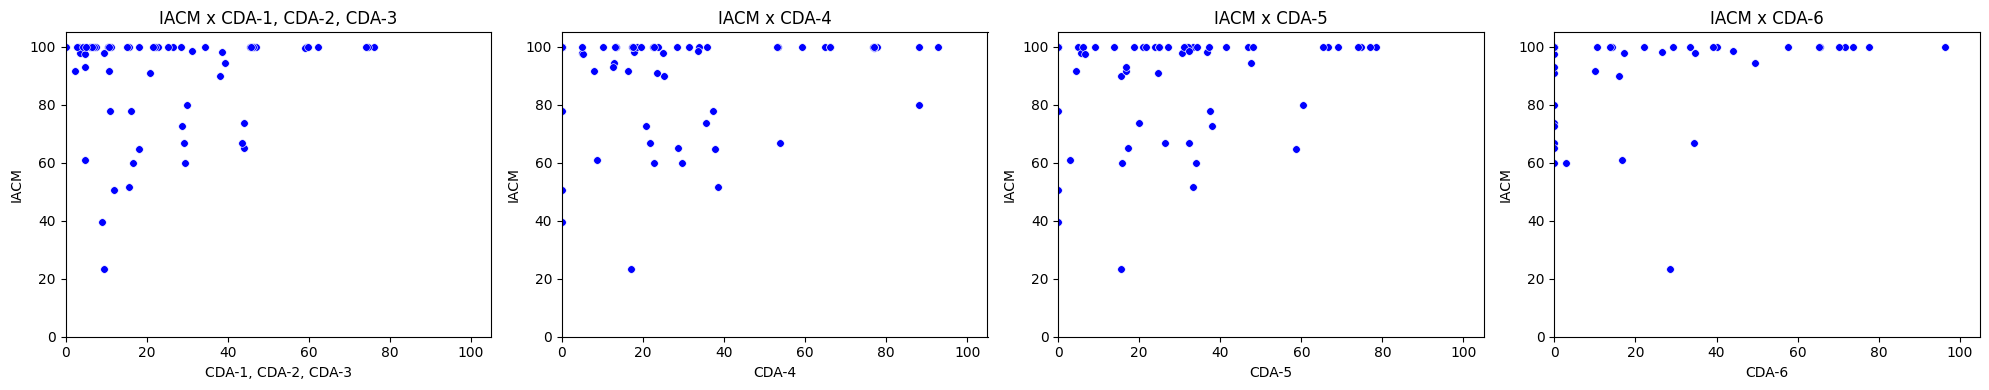

In [29]:
# Exibi os gráficos com os valores do IACM e o percentual de servidores efetivos 
# em cargos de comissão ('CDA-1, CDA-2, CDA-3', 'CDA-4', 'CDA-5' e 'CDA-6')

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))
ax = axes[0]
sns.scatterplot(data=df_iam_efetivos_comissao[['IACM','CDA-1, CDA-2, CDA-3']], x='CDA-1, CDA-2, CDA-3', y='IACM', ax=ax, s=30, color='blue')
ax.set_xlim(0, 105)
ax.set_ylim(0, 105)
ax.set_title(f'IACM x CDA-1, CDA-2, CDA-3')

ax = axes[1]
sns.scatterplot(data=df_iam_efetivos_comissao[['IACM','CDA-4']], x='CDA-4', y='IACM', ax=ax, s=30, color='blue')
ax.set_xlim(0, 105)
ax.set_ylim(0, 105)
ax.set_title(f'IACM x CDA-4')

ax = axes[2]
sns.scatterplot(data=df_iam_efetivos_comissao[['IACM','CDA-5']], x='CDA-5', y='IACM', ax=ax, s=30, color='blue')
ax.set_xlim(0, 105)
ax.set_ylim(0, 105)
ax.set_title(f'IACM x CDA-5')

ax = axes[3]
sns.scatterplot(data=df_iam_efetivos_comissao[['IACM','CDA-6']], x='CDA-6', y='IACM', ax=ax, s=30, color='blue')
ax.set_xlim(0, 105)
ax.set_ylim(0, 105)
ax.set_title(f'IACM x CDA-6')

plt.tight_layout()
plt.savefig("figura_C2.png")
plt.show()

In [30]:
# Cria a tabela com o cálculo da correlação estatística entre as variáveis
pearson = df_iam_efetivos_comissao.corr(numeric_only=True, method="pearson")['IACM']
spearman = df_iam_efetivos_comissao.corr(numeric_only=True, method="spearman")['IACM']
kendall = df_iam_efetivos_comissao.corr(numeric_only=True, method="kendall")['IACM']
df_iam_efetivos_comissao_corr = pd.DataFrame(pearson).rename(columns={'IACM':'Pearson'})
df_iam_efetivos_comissao_corr = pd.concat([df_iam_efetivos_comissao_corr, pd.DataFrame(spearman).rename(columns={'IACM':'Spearman'})], axis=1)
df_iam_efetivos_comissao_corr = pd.concat([df_iam_efetivos_comissao_corr, pd.DataFrame(kendall).rename(columns={'IACM':'Kendall'})], axis=1)
df_iam_efetivos_comissao_corr.to_html('tabela_C2.html')
df_iam_efetivos_comissao_corr

,Pearson,Spearman,Kendall
IACM,1.000000,1.000000,1.000000
"CDA-1, CDA-2, CDA-3",0.163976,0.109582,0.087841
CDA-4,0.183712,0.151746,0.103407
CDA-5,0.177193,0.153634,0.118718
CDA-6,0.192813,0.156437,0.133602


**⭐ Visão geral**

Todos os coeficientes estão entre **0.08 e 0.19**, o que significa:

✔ **Correlação positiva muito fraca**
✔ As variáveis **andam na mesma direção**, mas **a força da relação é baixa**
✔ Nada indica uma relação linear ou monotônica forte
✔ Ainda assim, existe um **sinal consistente**: todos os coeficientes são positivos → quando o CDA aumenta, o IACM tende a aumentar um pouco.

📌 **Interpretação detalhada variável por variável**
**1) IACM × (CDA-1, CDA-2, CDA-3)**

**Pearson: 0.1639** → relação linear **fraca**
**Spearman: 0.1096** → tendência monotônica **muito fraca**
**Kendall: 0.0878** → tendência ainda mais fraca

**✔ Conclusão**

Há uma **correlação positiva fraca** entre o IACM e o conjunto CDA-1/2/3.
O aumento desses indicadores parece acompanhar aumentos do IACM, mas a relação **não é forte** nem explicativa.

**2) IACM × CDA-4**

**Pearson: 0.1837** → correlação linear **fraca (ligeiramente maior)**
**Spearman: 0.1517** → tendência monotônica **fraca**
**Kendall: 0.1034** → mesma tendência

**✔ Conclusão**

Entre todas as variáveis, o **CDA-4 é um dos que mais se correlaciona com o IACM**, ainda que de forma fraca.
Existe uma leve associação: órgãos com melhor desempenho no CDA-4 tendem a ter IACM um pouco maior.

**3) IACM × CDA-5**

**Pearson: 0.1771** → correlação linear **fraca**
**Spearman: 0.1536** → tendência monotônica **fraca**
**Kendall: 0.1187** → reforça a tendência

**✔ Conclusão**

O CDA-5 tem correlação positiva e fraca com o IACM, semelhante ao CDA-4.
Há indício de que melhor desempenho no CDA-5 acompanha aumentos no IACM, mas sem força estatística suficiente para previsões.

**4) IACM × CDA-6**

**Pearson: 0.1928** → **maior correlação da tabela** (ainda assim fraca)
**Spearman: 0.1564** → tendência monotônica também **fraca**
**Kendall: 0.1336** → reforça que é o mais próximo de uma relação, mas ainda baixo

**✔ Conclusão**

O **CDA-6 é o que melhor se correlaciona com o IACM**, embora o valor ainda seja considerado **fraco** na escala de correlação.
Isso sugere que o CDA-6 influencia (ou acompanha) mais fortemente o IACM do que os demais indicadores.

**🟦 Síntese final**

Os resultados de correlação mostram que todas as variáveis CDA apresentam **correlação positiva e fraca** com o IACM.
Isso significa que:

Quando um CDA aumenta, o IACM tende a aumentar também
No entanto, a força da relação é baixa
As variáveis **não são boas preditoras individuais** do IACM
**CDA-6** apresenta a maior correlação, seguido de **CDA-4** e **CDA-5**
O conjunto **CDA-1,2,3** tem a menor correlação positiva

Em termos práticos:

👉 Há uma **associação consistente, porém fraca,** entre desempenho nos CDAs e IACM.
👉 O IACM **não depende fortemente** de nenhuma dessas variáveis analisadas isoladamente.
👉 Os CDAs podem contribuir para o IACM, mas somente como parte de um conjunto maior de fatores.